# Notebook 5: Results and Evaluation

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import  mean_squared_error, r2_score, log_loss, brier_score_loss
import joblib

import math

# Set max column width to None.
pd.set_option('display.max_colwidth', None)

# Import training and test sets.
df_03_23 = pd.read_csv('df_03_23.csv', index_col = 0)
df_24 = pd.read_csv('df_24.csv', index_col = 0)

## Log Loss and Brier Score Loss Comparison

In [2]:
# View training set metrics.
print(f'2003-2023 Log Loss (Model): {log_loss(df_03_23['home_win'], df_03_23['y_pred']):.6f}')
print(f'2003-2023 Log Loss (Sportsbook): {log_loss(df_03_23['home_win'], df_03_23['vegas_home_wp']):.6f}')
print()
print(f'2003-2023 Brier Score (Model): {brier_score_loss(df_03_23['home_win'], df_03_23['y_pred']):.6f}')
print(f'2003-2023 Brier Score (Sportsbook): {brier_score_loss(df_03_23['home_win'], df_03_23['vegas_home_wp']):.6f}')

2003-2023 Log Loss (Model): 0.440330
2003-2023 Log Loss (Sportsbook): 0.439266

2003-2023 Brier Score (Model): 0.146132
2003-2023 Brier Score (Sportsbook): 0.145770


Log Loss and Brier Scores are excellent ways to measure how well predicted probabilities align with binary outcomes. A lower score is better. Our model's performance is close to the sportsbook baseline, indicating it reproduces market-level accuracy. However, the sportsbook maintains a slight edge, likely due to incorporating information beyond play-level features (e.g., injuries, weather). 

We also compare the unseen 2024 predictions from our holdout set the same way.

In [227]:
# View test set metrics.
print(f'2024 Log Loss (Model): {log_loss(df_24['home_win'], df_24['y_pred']):.6f}')
print(f'2024 Log Loss (Sportsbook): {log_loss(df_24['home_win'], df_24['vegas_home_wp']):.6f}')
print()
print(f'2024 Brier Score (Model): {brier_score_loss(df_24['home_win'], df_24['y_pred']):.6f}')
print(f'2024 Brier Score (Sportsbook): {brier_score_loss(df_24['home_win'], df_24['vegas_home_wp']):.6f}')

2024 Log Loss (Model): 0.416578
2024 Log Loss (Sportsbook): 0.414921

2024 Brier Score (Model): 0.137133
2024 Brier Score (Sportsbook): 0.136276


Scores are close again, but the sportsbook still has an edge. 

We create a scatterplot to compare the model's predictions to the sportsbook probabilities.

## Scatterplot

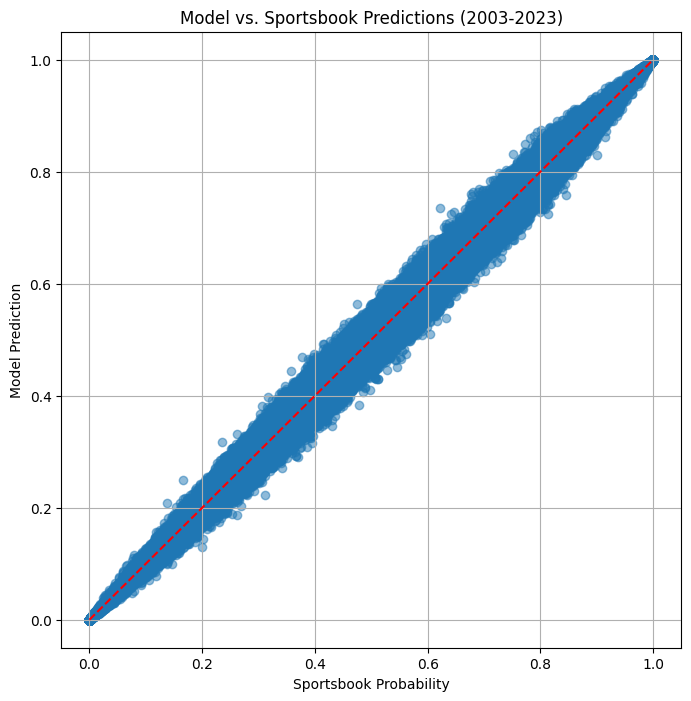

In [259]:
# Create scatterplot.
plt.figure(figsize=(8, 8))
plt.scatter(df_03_23['y_pred'], df_03_23['vegas_home_wp'], alpha=0.5)

# Set grid area and diagonal.
plt.plot([0, 1], [0, 1], 'r--')  

# Set labels and title.
plt.xlabel("Sportsbook Probability")
plt.ylabel("Model Prediction")
plt.title("Model vs. Sportsbook Predictions (2003-2023)")
plt.grid(True)
plt.show()

The clustering along the diagonal confirms our model tracks closely with sportsbook probabilities, with smaller differences near the extremes and larger differences around mid-range probabilities. There are a few outliers, but none extreme.

The wider spread in mid-range probabilities suggests our model may be less confident in balanced games, which could be an area for targeted refinement.

## Distribution plot

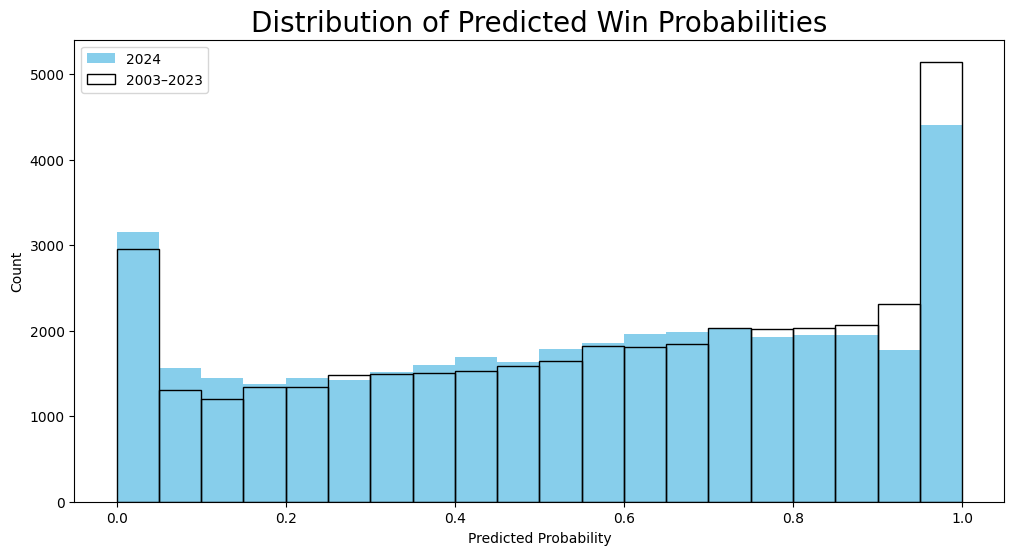

In [257]:
# Plot distribution.
plt.figure(figsize = (12,6))
plt.hist(df_24['y_pred'], bins=20, label='2024', color='skyblue')

# Sample training set to test set size.
plt.hist(df_03_23['y_pred'].sample(df_24.shape[0]), bins=20, label='2003–2023', fill = None)

plt.title('Distribution of Predicted Win Probabilities', fontsize = 20)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

The distribution of predicted probabilities is similar between the training and test sets, with the model appearing slightly more conservative on the 2024 data.

In [215]:
print('2003-2023 Home Win Percentage:', round(df_03_23.groupby('game_id')['home_win'].mean().mean()*100, 2))
print('2024 Home Win Percentage:', round(df_24.groupby('game_id')['home_win'].mean().mean()*100, 2))

2003-2023 Home Win Percentage: 56.42
2024 Home Win Percentage: 54.74


Interestingly, the home team win rate dropped from 56.4% in 2003-2023 to 54.7% in 2024. This distribution shift highlights the importance of temporal validation: as underlying league dynamics change, the model adapts by lowering the predicted home win probabilities.

## Calibration Plot

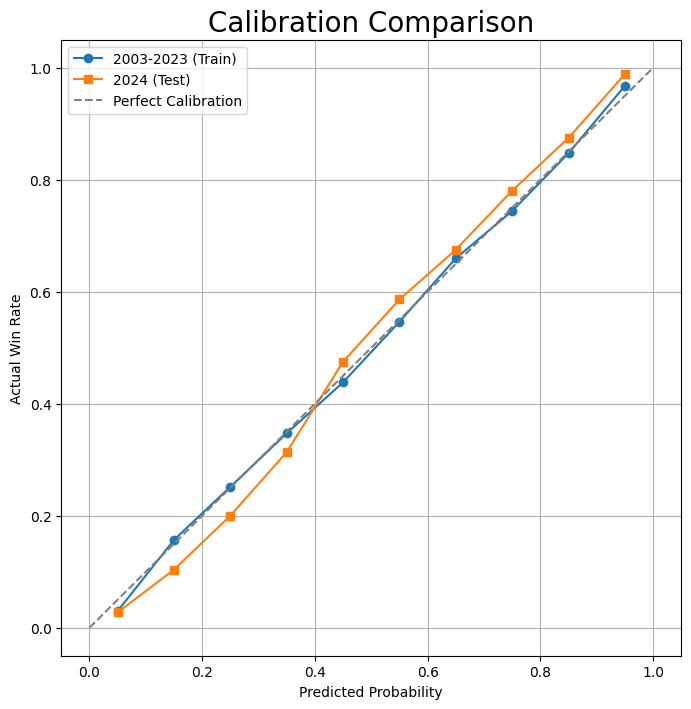

In [258]:
# Set bins.
plt.figure(figsize = (8,8))
bins = np.linspace(0, 1, 11)

# Explicitly define centers of bins as our X variable.
centers = np.arange(.05, 1, .1)

# Bin data.
df_03_23['y_pred_bin'] = pd.cut(df_03_23['y_pred'], bins = bins)
df_train_grouped = df_03_23.groupby('y_pred_bin', observed=False)['home_win'].mean().reset_index()

df_24['y_pred_bin'] = pd.cut(df_24['y_pred'], bins = bins)
df_test_grouped = df_24.groupby('y_pred_bin', observed=False)['home_win'].mean().reset_index()

# Plot data.
plt.plot(centers, df_train_grouped['home_win'], marker = 'o', label = '2003-2023 (Train)')
plt.plot(centers, df_test_grouped['home_win'], marker = 's', label = '2024 (Test)')
plt.plot([0,1], [0, 1],  '--', color = 'gray', label = 'Perfect Calibration')
plt.legend()
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Win Rate')
plt.title('Calibration Comparison', fontsize = 20)
plt.grid(True)

Calibration is critical for probability models since users rely on predicted values as decision thresholds. 

Our model shows good overall calibration, with minor bias (optimistic <0.4, conservative >0.4). This level of calibration compares favorably to published sports probability models, reinforcing its reliability.

To explore this further, we bin variables and visualize loss difference to identify areas where the model may struggle to generalize.

## Loss Plots

In [8]:
# Bin data
df_03_23['pred_diff_bin'] = pd.cut(df_03_23['pred_diff'], bins = np.linspace(-.05, .05, 25))
df_03_23['time_bin'] = pd.cut(df_03_23['game_seconds_remaining'], bins=30)
df_03_23['score_diff_bin'] = pd.cut(df_03_23['home_score_differential'], bins=np.linspace(-14, 14, 15))
df_03_23['spread_bin'] = pd.cut(df_03_23['home_spread_line'], bins=np.arange(-10, 10, 1))
# df_03_23['spread_bin'] = 

loss_dict = {
    'loss_by_pred_diff':'pred_diff_bin',
    'loss_by_time':'time_bin',
    'loss_by_score_diff':'score_diff_bin',
    'loss_by_spread':'spread_bin'
}

# Reusable function for creating loss dataframes.
def create_groups(dataframe):
    loss_dataframes = {}
    for group, bin in loss_dict.items():
        loss_dataframes[group] = (
            dataframe.groupby(bin, observed=True, group_keys=False)
            .apply(lambda g: pd.Series({
                'model_log_loss': log_loss(g['home_win'], g['y_pred'], labels=[0, 1]),
                'sportsbook_log_loss': log_loss(g['home_win'], g['vegas_home_wp'], labels=[0, 1]),
                'model_brier_score_loss': brier_score_loss(g['home_win'], g['y_pred'], labels = [0, 1]),
                'sportsbook_brier_score_loss': brier_score_loss(g['home_win'], g['vegas_home_wp'], labels = [0, 1]),
                'count': len(g)
            }), include_groups = False)
            .reset_index()
        )
        loss_dataframes[group]['bin_center'] = loss_dataframes[group][bin].apply(lambda x:x.mid)
        loss_dataframes[group]['log_loss_diff'] = loss_dataframes[group]['sportsbook_log_loss'] - loss_dataframes[group]['model_log_loss']
        loss_dataframes[group]['brier_score_loss_diff'] = loss_dataframes[group]['sportsbook_brier_score_loss'] - loss_dataframes[group]['model_brier_score_loss']
    return loss_dataframes
    
loss_dataframes = create_groups(df_03_23)

# Extract grouped dataframes.
for name, df_binned in loss_dataframes.items():
    globals()[name] = df_binned

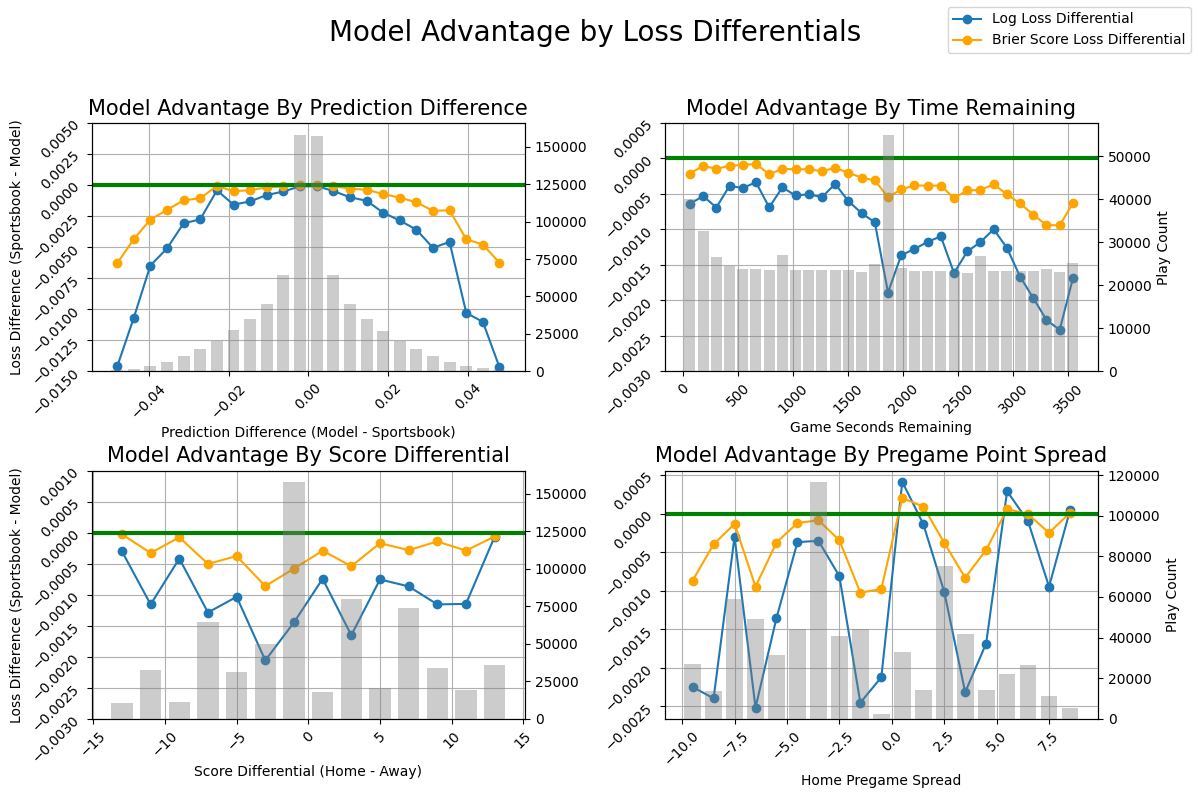

In [9]:
# Instantiate subplots.
fig, axs = plt.subplots(2, 2, figsize=(12,8)) #, constrained_layout = True)

# By prediction difference.
axs[0, 0].plot(
    loss_by_pred_diff['bin_center'], 
    loss_by_pred_diff['log_loss_diff'], 
    marker='o'
)
axs[0, 0].plot(
    loss_by_pred_diff['bin_center'], 
    loss_by_pred_diff['brier_score_loss_diff'], 
    marker='o',
    color = 'orange'
)
axs[0, 0].axhline(0, color='green', linewidth = 3)
axs[0, 0].tick_params(rotation=45)
axs[0, 0].set_xlabel('Prediction Difference (Model - Sportsbook)')
axs[0, 0].set_ylabel('Loss Difference (Sportsbook - Model)')

ax0 = axs[0,0].twinx()
ax0.bar(
    loss_by_pred_diff['bin_center'], 
    loss_by_pred_diff['count'], 
    width = .003, 
    color = 'gray', 
    alpha = .4, 
    label = 'Play Count'
)
# ax0.set_ylabel('Play Count')
axs[0, 0].set_title('Model Advantage By Prediction Difference', fontsize = 15)
axs[0, 0].grid(True)


# By time remaining.
axs[0, 1].plot(
    loss_by_time['bin_center'], 
    loss_by_time['log_loss_diff'], 
    marker='o'
)
axs[0, 1].plot(
    loss_by_time['bin_center'], 
    loss_by_time['brier_score_loss_diff'], 
    marker='o',
    color = 'orange'
)
axs[0, 1].axhline(0, color='green', linewidth = 3)
axs[0, 1].tick_params(rotation=45)
axs[0, 1].set_xlabel('Game Seconds Remaining')
# axs[0, 1].set_ylabel('Log Loss Difference (Sportsbook - Model)')
ax1 = axs[0, 1].twinx()
ax1.bar(
    loss_by_time['bin_center'], 
    loss_by_time['count'], 
    width = 100, 
    color = 'gray', 
    alpha = .4, 
    label = 'Play Count'
)
ax1.set_ylabel('Play Count')
axs[0, 1].set_title('Model Advantage By Time Remaining', fontsize = 15)
axs[0, 1].grid(True)


# By score differential.
axs[1, 0].plot(
    loss_by_score_diff['bin_center'], 
    loss_by_score_diff['log_loss_diff'], 
    marker='o'
)
axs[1, 0].plot(
    loss_by_score_diff['bin_center'], 
    loss_by_score_diff['brier_score_loss_diff'], 
    marker='o',
    color = 'orange'
)
axs[1, 0].axhline(0, color='green', linewidth = 3)
axs[1, 0].tick_params(rotation=45)
axs[1, 0].set_xlabel('Score Differential (Home - Away)')
axs[1, 0].set_ylabel('Loss Difference (Sportsbook - Model)')

ax2 = axs[1, 0].twinx()
ax2.bar(
    loss_by_score_diff['bin_center'], 
    loss_by_score_diff['count'], 
    width = 1.5, 
    color = 'gray', 
    alpha = .4, 
    label = 'Play Count'
)
# ax2.set_ylabel('Play Count')
axs[1, 0].set_title('Model Advantage By Score Differential', fontsize = 15)
axs[1, 0].grid(True)


# By point spread.
axs[1, 1].plot(
    loss_by_spread['bin_center'], 
    loss_by_spread['log_loss_diff'], 
    marker='o'
)
axs[1, 1].plot(
    loss_by_spread['bin_center'], 
    loss_by_spread['brier_score_loss_diff'], 
    marker='o',
    color = 'orange'
)

axs[1, 1].axhline(0, color='green', linewidth = 3)
axs[1, 1].tick_params(rotation=45)
axs[1, 1].set_xlabel('Home Pregame Spread')
# axs[1, 1].set_ylabel('Log Loss Difference (Sportsbook - Model)')

ax3 = axs[1,1].twinx()
ax3.bar(
    loss_by_spread['bin_center'], 
    loss_by_spread['count'], 
    width = .8, 
    color = 'gray', 
    alpha = .4, 
    label = 'Play Count'
)

ax3.set_ylabel('Play Count')
axs[1, 1].set_title('Model Advantage By Pregame Point Spread', fontsize = 15)
axs[1, 1].grid(True)

axs[0, 0].set_ylim(-.015, .005)
axs[0, 1].set_ylim(-.003, .0005)
axs[1, 0].set_ylim(-.003, .001)
# axs[1, 1].set_ylim(-.001, .005)

fig.legend(['Log Loss Differential', 'Brier Score Loss Differential'], loc = 'upper right')
fig.tight_layout()
fig.subplots_adjust(top = .85, hspace = .4)
plt.suptitle('Model Advantage by Loss Differentials', fontsize = 20)
plt.show()

The model does not perform well on the full dataset compared to the sportsbook model. However there are a couple of areas in the point spread plot where both loss functions cross into the positive region. 

The binning makes these areas unclear. We plot each point spread in greater detail to gain clarity.

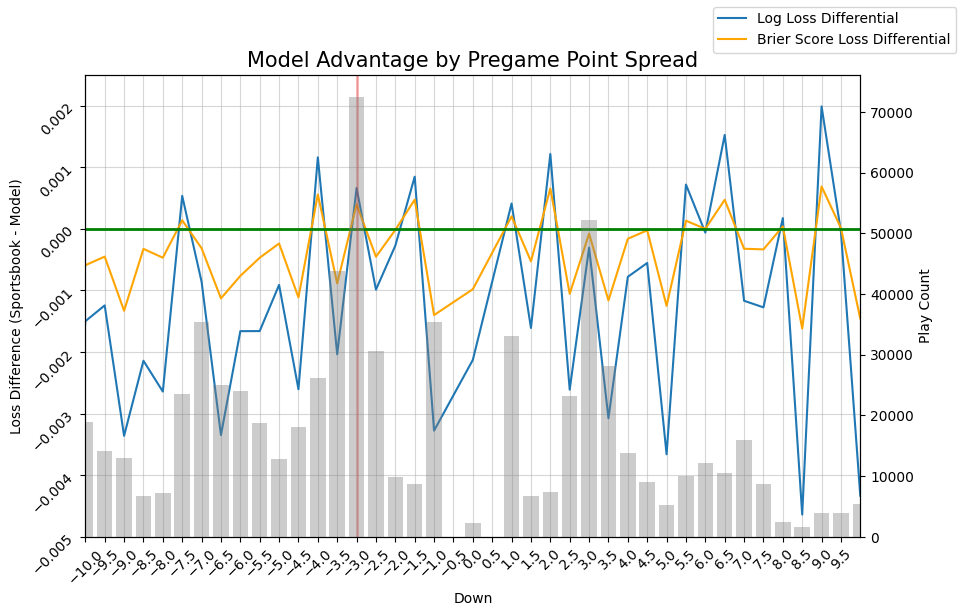

In [5]:
# Group by point spread.
df_grouped = df_03_23.groupby('home_spread_line').apply(lambda g: pd.Series({
    'model_spread_log_loss': log_loss(g['home_win'], g['y_pred'], labels = [0, 1]),
    'sportsbook_spread_log_loss': log_loss(g['home_win'], g['vegas_home_wp'], labels = [0, 1]),
    'model_spread_brier_score_loss': brier_score_loss(g['home_win'], g['y_pred'], labels = [0, 1]),
    'sportsbook_spread_brier_score_loss': brier_score_loss(g['home_win'], g['vegas_home_wp'], labels = [0, 1]),
    'count': len(g)
}), include_groups = False).reset_index()
    
# Calculate loss delta.                                
df_grouped['log_loss_diff'] = df_grouped['sportsbook_spread_log_loss'] - df_grouped['model_spread_log_loss']
df_grouped['brier_score_loss_diff'] = df_grouped['sportsbook_spread_brier_score_loss'] - df_grouped['model_spread_brier_score_loss']   

# Instantiate plot.
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(df_grouped['home_spread_line'],
        df_grouped['log_loss_diff'])
ax.plot(df_grouped['home_spread_line'],
        df_grouped['brier_score_loss_diff'],
        color = 'orange')

ax.axhline(0, color='green', linewidth = 2)

ax.grid(True, alpha = .5)
ax.set_xticks(np.arange(-10, 10, .5))
ax.tick_params(rotation = 45)
ax.set_xlim(-10, 10)

ax2 = ax.twinx()
ax2.bar(
    df_grouped['home_spread_line'], 
    df_grouped['count'], 
    width = .4, 
    color = 'gray', 
    alpha = .4, 
    label = 'Play Count'
)

ax.set_ylim(-.005, .0025)
spreads = [-3]
for i in spreads:
    ax.axvline(x= i, color='red',  linewidth=2, alpha=0.3)

ax.set_xlabel('Down')
ax.set_ylabel('Loss Difference (Sportsbook - Model)')
ax2.set_ylabel('Play Count')
fig.legend(['Log Loss Differential', 'Brier Score Loss Differential'])
# fig.tight_layout()
plt.title('Model Advantage by Pregame Point Spread', fontsize = 15)
plt.show()


3-point home favorites are not only the most common point spread, but our model also appears to generalize better than the sportsbook in this area. 

We subset by point spreads of -3.

## Log Loss and Brier Score Loss (2003-2023 Subset)

In [18]:
# Subset optimal spreads.
df_subset = df_03_23[df_03_23['home_spread_line'].isin(spreads)].copy()

# View losses.
print(f'Subset Log Loss (Model): {log_loss(df_subset['home_win'], df_subset['y_pred']):.6f}')
print(f'Subset Log Loss (Sportsbook): {log_loss(df_subset['home_win'], df_subset['vegas_home_wp']):.6f}')
print()
print(f'Subset Brier Score (Model): {brier_score_loss(df_subset['home_win'], df_subset['y_pred']):.6f}')
print(f'Subset Brier Score (Sportsbook): {brier_score_loss(df_subset['home_win'], df_subset['vegas_home_wp']):.6f}')
print()
print(f'Percentage of games: {round(len(np.unique(df_subset['game_id']))/len(np.unique(df_03_23['game_id']))*100, 3)}%')

Subset Log Loss (Model): 0.505990
Subset Log Loss (Sportsbook): 0.506655

Subset Brier Score (Model): 0.171637
Subset Brier Score (Sportsbook): 0.172034

Percentage of games: 9.364%


Our model is generalizing better than the sportsbook in this subset! We move forward with a similar subset on our unseen 2024 data.

Almost 10% of games are still included, which is over 1 per week. 

## Log Loss and Brier Score Loss (2024 Subset)

In [6]:
df_subset_24 = df_24[df_24['home_spread_line'].isin(spreads)].copy()
# df_subset_24 = df_subset_24[df_subset_24['game_seconds_remaining'] < 1800].copy()

# View losses.
print(f'2024 Subset Log Loss (Model): {log_loss(df_subset_24['home_win'], df_subset_24['y_pred']):.6f}')
print(f'2024 Subset Log Loss (Sportsbook): {log_loss(df_subset_24['home_win'], df_subset_24['vegas_home_wp']):.6f}')
print()
print(f'2024 Subset Brier Score (Model): {brier_score_loss(df_subset_24['home_win'], df_subset_24['y_pred']):.6f}')
print(f'2024 Subset Brier Score (Sportsbook): {brier_score_loss(df_subset_24['home_win'], df_subset_24['vegas_home_wp']):.6f}')
print()
print(f'Subset Percentage of games: {round(len(np.unique(df_subset_24['game_id']))/len(np.unique(df_24['game_id']))*100, 3)}%')

2024 Subset Log Loss (Model): 0.496310
2024 Subset Log Loss (Sportsbook): 0.499148

2024 Subset Brier Score (Model): 0.171007
2024 Subset Brier Score (Sportsbook): 0.172185

Subset Percentage of games: 8.772%


Our model is still generalizing better than the sportsbook on unseen data, with just under 9% of 2024 games.

## 2024 Test Data Scatterplot

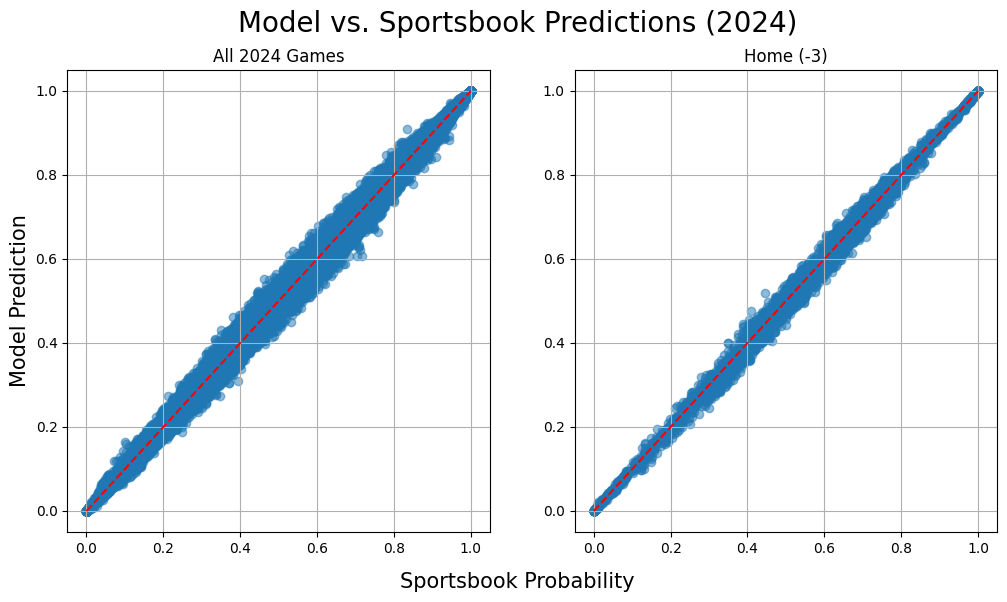

In [20]:
# Create scatterplot.
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
# plt.figure(figsize=(8, 8))

ax[0].scatter(df_24['y_pred'], df_24['vegas_home_wp'], alpha=0.5)

# Set grid area and diagonal.
ax[0].plot([0, 1], [0, 1], 'r--')  
ax[0].set_title('All 2024 Games')

ax[1].scatter(df_subset_24['y_pred'], df_subset_24['vegas_home_wp'], alpha=0.5)

# Set grid area and diagonal.
ax[1].plot([0, 1], [0, 1], 'r--')  
ax[1].set_title('Home (-3)')

# Set labels and title.
fig.supxlabel("Sportsbook Probability", fontsize = 15)
ax[0].set_ylabel("Model Prediction", fontsize = 15)
fig.suptitle("Model vs. Sportsbook Predictions (2024)", fontsize = 20)
ax[0].grid(True)
ax[1].grid(True)
plt.show()

Predictions still closely match the sportsbook.

We plot 2024 the same as above. We also visualize the advantage by down instead of point spread, as the latter is uniform across this subset.

## 2024 Test Data Loss Plots

In [10]:
# Bin subset.
df_subset_24['pred_diff_bin'] = pd.cut(df_subset_24['pred_diff'], bins = np.linspace(-.05, .05, 25))
df_subset_24['time_bin'] = pd.cut(df_subset_24['game_seconds_remaining'], bins=30)
df_subset_24['score_diff_bin'] = pd.cut(df_subset_24['home_score_differential'], bins=np.linspace(-14, 14, 15))
df_subset_24['spread_bin'] = pd.cut(df_subset_24['home_spread_line'], bins=np.arange(-10, 10, 1))
# Create dictionary of binned dataframes.
subset_loss_dataframes = create_groups(df_subset_24)

# Extract grouped dataframes.
for name, dataframe in subset_loss_dataframes.items():
    globals()[name] = dataframe

# Create loss by down grouped dataframe.
loss_by_down = (
    df_subset_24.groupby('down', observed=True, group_keys=False)
    .apply(lambda g: pd.Series({
        'model_log_loss': log_loss(g['home_win'], g['y_pred'], labels=[0, 1]),
        'sportsbook_log_loss': log_loss(g['home_win'], g['vegas_home_wp'], labels=[0, 1]),
        'model_brier_score_loss': brier_score_loss(g['home_win'], g['y_pred'], labels = [0, 1]),
        'sportsbook_brier_score_loss': brier_score_loss(g['home_win'], g['vegas_home_wp'], labels = [0, 1]),
        'count': len(g)
    }), include_groups = False)
    .reset_index()
)


# Calculate loss differential.
loss_by_down['log_loss_diff'] = loss_by_down['sportsbook_log_loss'] - loss_by_down['model_log_loss']
loss_by_down['brier_score_loss_diff'] = loss_by_down['sportsbook_brier_score_loss'] - loss_by_down['model_brier_score_loss']

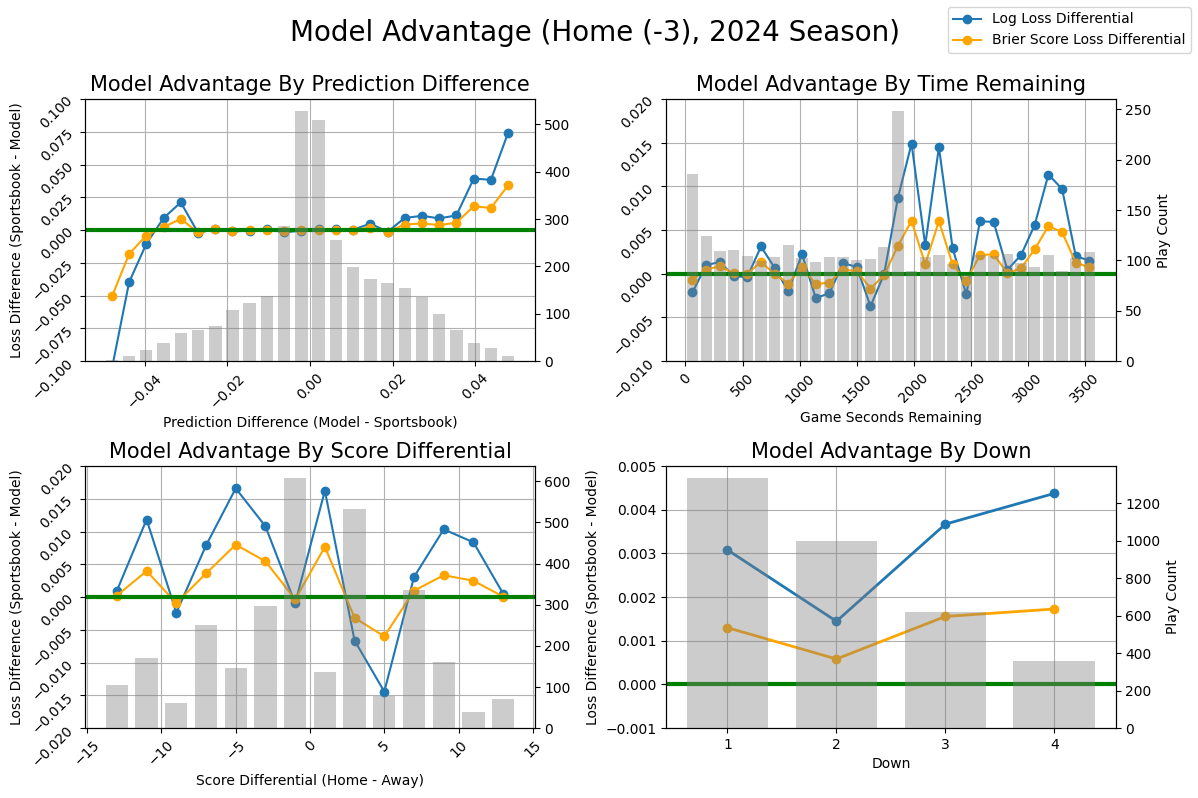

In [11]:
# Configure subplots.
fig, axs = plt.subplots(2, 2, figsize=(12,8)) #, constrained_layout = True)


# By prediction difference.
axs[0, 0].plot(
    loss_by_pred_diff['bin_center'], 
    loss_by_pred_diff['log_loss_diff'], 
    marker='o'
)
axs[0, 0].plot(
    loss_by_pred_diff['bin_center'], 
    loss_by_pred_diff['brier_score_loss_diff'], 
    marker='o',
    color = 'orange'
)
axs[0, 0].axhline(0, color='green', linewidth = 3)
axs[0, 0].tick_params(rotation=45)
axs[0, 0].set_xlabel('Prediction Difference (Model - Sportsbook)')
axs[0, 0].set_ylabel('Loss Difference (Sportsbook - Model)')
ax0 = axs[0,0].twinx()
ax0.bar(
    loss_by_pred_diff['bin_center'], 
    loss_by_pred_diff['count'], 
    width = .003, 
    color = 'gray', 
    alpha = .4, 
    label = 'Play Count'
)
# ax0.set_ylabel('Play Count')
axs[0, 0].set_title('Model Advantage By Prediction Difference', fontsize = 15)
axs[0, 0].grid(True)


# By time remaining.
axs[0, 1].plot(
    loss_by_time['bin_center'], 
    loss_by_time['log_loss_diff'], 
    marker='o'
)
axs[0, 1].plot(
    loss_by_time['bin_center'], 
    loss_by_time['brier_score_loss_diff'], 
    marker='o',
    color = 'orange'
)
axs[0, 1].axhline(0, color='green', linewidth = 3)
axs[0, 1].tick_params(rotation=45)
axs[0, 1].set_xlabel('Game Seconds Remaining')
# axs[0, 1].set_ylabel('Log Loss Difference (Sportsbook - Model)')

ax1 = axs[0, 1].twinx()
ax1.bar(
    loss_by_time['bin_center'], 
    loss_by_time['count'], 
    width = 100, 
    color = 'gray', 
    alpha = .4, 
    label = 'Play Count'
)
ax1.set_ylabel('Play Count')
axs[0, 1].set_title('Model Advantage By Time Remaining', fontsize = 15)
axs[0, 1].grid(True)


# By score differential.
axs[1, 0].plot(
    loss_by_score_diff['bin_center'], 
    loss_by_score_diff['log_loss_diff'], 
    marker='o'
)
axs[1, 0].plot(
    loss_by_score_diff['bin_center'], 
    loss_by_score_diff['brier_score_loss_diff'], 
    marker='o',
    color = 'orange'
)
axs[1, 0].axhline(0, color='green', linewidth = 3)
axs[1, 0].tick_params(rotation=45)
axs[1, 0].set_xlabel('Score Differential (Home - Away)')
axs[1, 0].set_ylabel('Loss Difference (Sportsbook - Model)')

ax2 = axs[1, 0].twinx()
ax2.bar(
    loss_by_score_diff['bin_center'], 
    loss_by_score_diff['count'], 
    width = 1.5, 
    color = 'gray', 
    alpha = .4, 
    label = 'Play Count'
)
# ax2.set_ylabel('Play Count')
axs[1, 0].set_title('Model Advantage By Score Differential', fontsize = 15)
axs[1, 0].grid(True)


# By down.
axs[1, 1].plot(
    loss_by_down['down'], 
    loss_by_down['log_loss_diff'], 
    marker = 'o', 
    linewidth = 2
)
axs[1, 1].plot(
    loss_by_down['down'], 
    loss_by_down['brier_score_loss_diff'], 
    color = 'orange',
    marker = 'o',
    linewidth = 2
)
axs[1, 1].axhline(0, color='green', linewidth = 3)
axs[1, 1].set_xlabel('Down')
axs[1, 1].set_ylabel('Loss Difference (Sportsbook - Model)')

# plt.title('Model Advantage Over Sportsbook by Pregame Spread')
ax3 = axs[1, 1].twinx()
ax3.bar(
    loss_by_down['down'], 
    loss_by_down['count'], 
    width = .75, 
    color = 'gray', 
    alpha = .4, 
    label = 'Play Count'
)
ax3.set_xticks([1, 2, 3, 4])
ax3.set_ylabel('Play Count')
axs[1, 1].set_title('Model Advantage By Down', fontsize = 15)
axs[1, 1].grid(True)

axs[0, 0].set_ylim(-.1, .1)
axs[0, 1].set_ylim(-.01, .02)
axs[1, 0].set_ylim(-.02, .02)
axs[1, 1].set_ylim(-.001, .005)

fig.legend(['Log Loss Differential', 'Brier Score Loss Differential'], loc = 'upper right')
fig.tight_layout()
fig.subplots_adjust(top = .88, hspace = .4)
plt.suptitle(f'Model Advantage (Home ({spreads[0]}), 2024 Season)', fontsize = 20)
plt.show()

Much better performance on the 2024 3-point favorite subset, but it's unclear if this is a meaningful advantage. 

It's worth noting that the model now performs better in the first half, as well as at higher prediction deltas and negative score differentials.

We simulate wagers to see if the model generalizes well enough to edge out the house spread. 

## Wager Simulation

In [12]:
# Convert probability to implied probability with house edge.
def prob_to_market_prob(prob):
    hold = 0.0476190476190477
    # hold = 0.0476
    p1 = prob
    p2 = 1-p1
    overround = 1 + hold
    fair_total = p1 + p2
    vig_p1 = min((p1 / fair_total) * overround, 0.9999)
    vig_p2 = overround - vig_p1
    return vig_p1, vig_p2

# Convert probability to American odds.
def prob_to_odds(prob):
    if prob > 0.5:
        return round(-prob / (1 - prob) * 100)
    else:
        return round((1 - prob) / prob * 100)

# Confirm odds output.
home_p = 0.5

market_prob_home, market_prob_away = prob_to_market_prob(home_p)
market_odds_home = round(prob_to_odds(market_prob_home), -(len(str(abs(prob_to_odds(market_prob_home))))-2))
market_odds_away = round(prob_to_odds(market_prob_away), -(len(str(abs(prob_to_odds(market_prob_away))))-2))

print('Implied Odds:')
print(f'Home: {market_odds_home}, Away: {market_odds_away}')

Implied Odds:
Home: -110, Away: -110


Sportsbook odds are working as intended.

In [13]:
# Combine functions.
def prob_to_market_odds(prob):
    inflated_prob = prob_to_market_prob(prob)[0]
    market_odds = prob_to_odds(inflated_prob)
    rounded_odds = int(round(market_odds, -(len(str(abs(market_odds)))-2)))

    # Cap underdog odds.
    if rounded_odds > 100:
        rounded_odds = min(rounded_odds, 5000)
    
    # Cap favorite odds.
    if rounded_odds < 100:
        rounded_odds = max(rounded_odds, -100000)
    if abs(rounded_odds) == 100:
        return f'(EVEN)'
    elif rounded_odds > 100:
        return f'(+{rounded_odds})'
    else:
        return f'({rounded_odds})'


We create a function that simulates wagers. We also set a threshold for prediction differences.  
If `y_pred` is above .5 *and greater* than the sportsbook's probability + threshold, we have action on the home team.  
If `y_pred` is below .5 *and less* than sportsbook probability - threshold, we have action on the away team.

In [14]:
# Create wager simulation function.
def simulate_wagers(df = None, threshold=0.00, risk=0, label = None):
    df = df.copy()
    df['action_side'] = 0

    # Home action.
    df.loc[(df['y_pred'] > df['vegas_home_wp'] + threshold) & (df['y_pred'] > 0.5), 'action_side'] = 1   

    # Away action.
    df.loc[(df['y_pred'] < df['vegas_home_wp'] - threshold) & (df['y_pred'] < 0.5), 'action_side'] = -1  

    # Subset wager action.
    df = df[df['action_side'] != 0]

    # Evaluate wagers based on game result.
    df['settled_win'] = ((df['home_win'] == 1) & (df['action_side'] == 1)) | ((df['home_win'] == 0) & (df['action_side'] == -1))

    # Add market odds columns with probability to odds function.
    df['market_home_odds'] = df.apply(lambda x:prob_to_market_odds(x['vegas_home_wp']), axis = 1)
    df['market_away_odds'] = df.apply(lambda x:prob_to_market_odds(.9999999-x['vegas_home_wp']), axis = 1)
    
    # Calculate net profit per wager.
    def calc_profit(row):
        if row['action_side'] == 1:  
            odds_val = row['market_home_odds']
        else:  
            odds_val = row['market_away_odds']
        if odds_val == '(EVEN)':
            odds_val = '(+100)'
        odds_val = int(odds_val[1:-1])
        payout = (risk * abs(odds_val)) / 100 if odds_val > 0 else (risk * 100) / abs(odds_val)
        return payout if row['settled_win'] else -risk  

    df['profit'] = df.apply(calc_profit, axis=1)

    # Split dataframe into home and away action.
    df_home = df[df['action_side'] == 1].copy()
    df_away = df[df['action_side'] == -1].copy()

    # Calculate cumulative profit.
    df_home['cumulative_profit'] = df_home['profit'].cumsum()
    df_home['wager_number'] = range(1, len(df_home) + 1)

    df_away['cumulative_profit'] = df_away['profit'].cumsum()
    df_away['wager_number'] = range(1, len(df_away) + 1)

    # Plot results.
    plt.figure(figsize=(10, 6))
    plt.plot(df_home['wager_number'], df_home['cumulative_profit'], label='Home Wagers')
    plt.plot(df_away['wager_number'], df_away['cumulative_profit'], label='Away Wagers', color='orange')
    plt.axhline(0, color='green', linewidth = 2)
    plt.title(f'Cumulative Profit (Threshold = {threshold}) {label}')
    plt.xlabel('Wager Number')
    plt.ylabel('Cumulative Profit (Units)')
    plt.legend(loc = 'lower left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    print(f"Total Wagers Simulated: {len(df)}")
    print(f"Home Wagers: {len(df_home)} | Win Rate: {df_home['settled_win'].mean():.2%} | Profit: {df_home['profit'].sum():+.2f} units")
    print(f"Away Wagers: {len(df_away)} | Win Rate: {df_away['settled_win'].mean():.2%} | Profit: {df_away['profit'].sum():+.2f} units")
    print(f"Total Profit: {df['profit'].sum():+.2f} units | Avg Profit per Wager: {df['profit'].mean():+.2f} units")

We first simulate the full 2024 season.

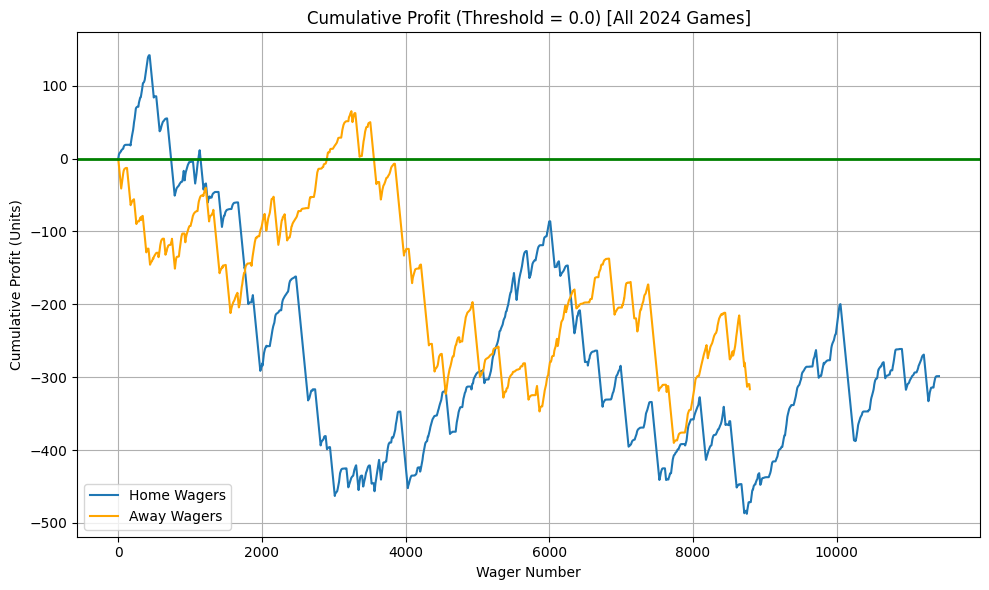

Total Wagers Simulated: 20219
Home Wagers: 11426 | Win Rate: 77.49% | Profit: -298.60 units
Away Wagers: 8793 | Win Rate: 76.28% | Profit: -316.52 units
Total Profit: -615.11 units | Avg Profit per Wager: -0.03 units


In [15]:
# Simulate wagers on entire season.
simulate_wagers(
    df=df_24,
    threshold=0.0,
    # threshold=0.045,
    risk=1,
    label = '[All 2024 Games]'
)

Net result is negative on the full season. 

Now we simulate wagers on the 3-point favorite subset.

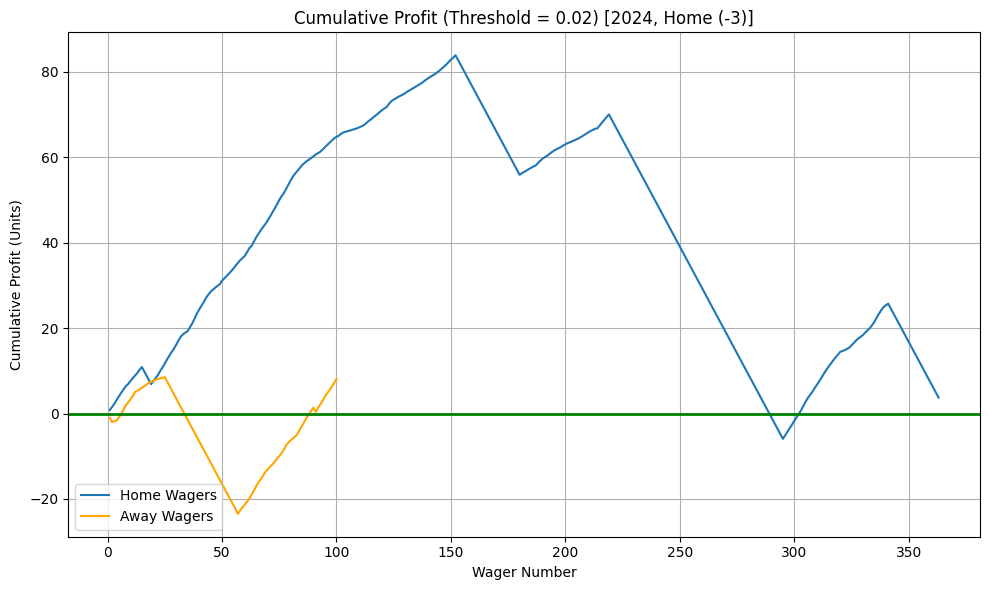

Total Wagers Simulated: 463
Home Wagers: 363 | Win Rate: 64.19% | Profit: +3.74 units
Away Wagers: 100 | Win Rate: 65.00% | Profit: +8.10 units
Total Profit: +11.84 units | Avg Profit per Wager: +0.03 units


In [21]:
spreads = [-3]
df_subset_24 = df_24[df_24['home_spread_line'].isin(spreads)].copy()
# df_subset_24 = df_subset_24[df_subset_24['game_seconds_remaining'] < 1800].copy()

# Simulate wagers on subset.
simulate_wagers(
    df=df_subset_24,
    threshold=0.02,
    risk=1,
    label='[2024, Home (-3)]'
)

Much better performance on the Home -3 subset! A small threshold yields a positive result, as does subsetting to the second half without a threshold.

## Results Summary

 - Model achieved Log Loss and Brier Scores close to sportsbook benchmarks.
 - Scatterplots confirmed alignment with sportsbook probabilities, with slight underconfidence in balanced games.
 - Temporal evaluation (2024 holdout set) showed our model adapts reasonably well to changes in league dynamics.
 - Calibration analysis demonstrated reliable probability estimates with minor bias.
 - Although profit margins are small, model yielded positive results with market-adjusted odds in certain scenarios such as 3-point home favorites with a small threshold. 

Overall, the model reproduces sportsbook-level accuracy while remaining transparent and explainable.
This supports its utility as a real-time win probability tool independent of proprietary sportsbook markets.